In [296]:
import pandas as pd
import os
import ast
import numpy as np
import math
import random
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import pickle
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, ZeroPadding1D, SimpleRNN, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import json
from keras.models import model_from_json

In [6]:
CHARACTER_LIST = [u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y']
nchar = len(CHARACTER_LIST)
CHARACTER_LIST.sort()
CHARACTER_DICT = set([u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y'])
MAX_SEQUENCE_LENGTH=46
MAX_MIC = 4
FONT_TO_USE = 'Arial'

In [21]:
def generate_embedding(matrix_dict,min_corr=0.99):
    distance_matrix = np.zeros([len(CHARACTER_LIST),len(CHARACTER_LIST)])
    for i,char1 in enumerate(CHARACTER_LIST):
        for j,char2 in enumerate(CHARACTER_LIST):
            if (char1,char2) in matrix_dict.keys():
                distance_matrix[i,j] = (matrix_dict[(char1,char1)]+matrix_dict[(char2,char2)]-2*matrix_dict[(char1,char2)]+0.)
            else:
                distance_matrix[i,j] = (matrix_dict[(char1,char1)]+matrix_dict[(char2,char2)]-2*matrix_dict[(char2,char1)]+0.)
    G_matrix = np.zeros([nchar,nchar])
    for i in range(nchar):
        for j in range(nchar):
            G_matrix[i,i] += distance_matrix[i,j]**2/nchar
            for k in range(nchar):
                G_matrix[i,i] -= distance_matrix[j,k]**2/(2*(nchar**2))

    for i in range(nchar):
        for j in range(nchar):
            G_matrix[i,j] = (G_matrix[i,i]+G_matrix[j,j]-distance_matrix[i,j]**2)/2
    values,vectors = np.linalg.eigh(G_matrix)
    corr = 0
    n_dimensions = 0
    while corr<min_corr:
        n_dimensions += 1
        sqrt_lambda_matrix = np.zeros([n_dimensions,n_dimensions])
        for i in range(n_dimensions):
            sqrt_lambda_matrix[i,i] = np.sqrt(values[i-n_dimensions])
        u_matrix = vectors[:,nchar-n_dimensions:nchar]
        product = np.matmul(sqrt_lambda_matrix,np.transpose(u_matrix))
        embedding_matrix = np.zeros([n_dimensions,nchar])
        for i in range(nchar):
            for j in range(n_dimensions):
                embedding_matrix[j,i] = product[n_dimensions-1-j,i]
        embedding_matrix = np.transpose(embedding_matrix)
        reconst_dist_matrix = np.zeros([nchar,nchar])
        for i in range(nchar):
            for j in range(nchar):
                to_set = np.linalg.norm(embedding_matrix[i,:]-embedding_matrix[j,:])
                reconst_dist_matrix[i,j] = to_set
        old=[]
        reconst=[]
        for i in range(nchar-1):
            for j in range(i+1,nchar):
                old.append(distance_matrix[i,j])
                reconst.append(reconst_dist_matrix[i,j])
        corr = np.corrcoef(old,reconst)[0,1]
    embedding_dict = {}
    for i,char in enumerate(CHARACTER_LIST):
        embedding_dict[char] = embedding_matrix[i].tolist()
    return embedding_dict

In [287]:
# Generate the input vectors for our model
# Each vector is two dimensional
# The first dimension represents the number of characters in the sequence (46 characters)
# Each character is a vector of length equal to the number of groupings of amino acids
# This grouping can be 1-1 (each amino acid gets its own group), or coarser
def df_to_input_vec(df,shuffle = False,embed_dict=None):
    cterminal_amidation = np.array(df.has_cterminal_amidation)

    vectors = []
    for row in df.iterrows():
        vectors.append(row_to_vector(row[1],embed_dict=embed_dict, shuffle_sequence=shuffle))

    vectors = np.array(vectors)

    labels = np.array(df.value)
    sample_weights = np.full(len(labels), 1)
    return vectors, labels, sample_weights

def generate_random_sequence(alphabet, length_of_sequence_min=0, length_of_sequence_max=MAX_SEQUENCE_LENGTH, include_C = True):
        sequence = ''
        choices = [char for char in alphabet if (include_C or char !='C')]
        counter = 0
        length_to_use = -10
        while counter<20 and (length_to_use < length_of_sequence_min or length_to_use > length_of_sequence_max):
            length_to_use = random.choice(SEQ_LENGTHS)
            counter += 1
        for _ in range(length_to_use):
            sequence += random.choice(choices)
        has_cterminal_amidation = random.uniform(0, 1)

        return {
            'sequence': sequence,
            'has_cterminal_amidation': has_cterminal_amidation>0.5
#             Used to be 0.5 but only 34% of positive data has amidation OOPS
        }

def add_random_negative_examples(vectors, labels, sample_weights, ratio, max_mic = None, include_cysteine = True):
    if not max_mic:
        max_mic = max(labels)
    # We will add randomly chosen sequences as negative examples
    # We will double the length of our training set

    len_vectors = ratio * len(vectors)
    negative_rows = []
    for i in range(len_vectors):
        negative_rows.append(row_to_vector(generate_random_sequence(list(CHARACTER_DICT),include_C = include_cysteine)))
    negative_vectors = np.array(negative_rows)
    vectors = np.concatenate((vectors, negative_vectors))
    negative_labels = np.full(len_vectors, max_mic)
    labels = np.concatenate((labels, negative_labels))
    # Weight all samples equally
    sample_weights = np.concatenate((sample_weights, np.full(len_vectors, 1)))
    return vectors, labels, sample_weights

def generate_train_test_splits(
        vectors, labels,
        extra_training_vectors=[], extra_training_labels=[], extra_sample_weights=[],
        cutoff=0.85
):
    cutoff = int(cutoff * len(labels))
    idx = range(len(vectors))
    random.shuffle(idx)
    reordered_vectors = vectors[idx]
    reordered_labels = labels[idx]
    reordered_sample_weights = sample_weights[idx]
    if len(extra_training_vectors) > 0:
        train_x = np.concatenate((reordered_vectors[:cutoff], extra_training_vectors))
        train_y = np.concatenate((reordered_labels[:cutoff], extra_training_labels))
        train_sample_weights = np.concatenate((reordered_sample_weights[:cutoff], pa_sample_weights))
    else:
        train_x = reordered_vectors[:cutoff]
        train_y = reordered_labels[:cutoff]
        train_sample_weights = reordered_sample_weights[:cutoff]
    test_x = reordered_vectors[cutoff:]
    test_y = reordered_labels[cutoff:]
    return train_x, train_y, test_x, test_y, train_sample_weights

# Convolutional NN
def conv_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convolutional NN
def conv_model_set_dropout(dropout_level=0.5,embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_level))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convolutional NN
def conv_model_move_dropout(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convolutional NN
def one_layer_conv_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def lstm_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(LSTM(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),
    ))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def two_layer_recurrent_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(SimpleRNN(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),return_sequences=True
    ))
    model.add(SimpleRNN(64))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def three_layer_recurrent_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(SimpleRNN(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),return_sequences=True
    ))
    model.add(SimpleRNN(64,return_sequences=True))
    model.add(SimpleRNN(64))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def one_layer_recurrent_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(SimpleRNN(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),return_sequences=False
    ))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def bilstm_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(Bidirectional(LSTM(
        64
    ),input_shape=(MAX_SEQUENCE_LENGTH, embed_length)))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def birecurrent_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(Bidirectional(SimpleRNN(
        64,return_sequences=False
    ),input_shape=(MAX_SEQUENCE_LENGTH, embed_length)))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

class EnsembleModel:
    def __init__(self,models,predict_method,max_mic_buffer=0.1):
        self.models = models
        self.predict_method = predict_method
        self.max_mic_buffer = max_mic_buffer
        
    def combine_predictions(self,predictions):
        if self.predict_method is 'average':
            return np.mean(predictions)
        elif self.predict_method is 'classify_then_average':
            actual_predictions = []
            for prediction in predictions:
                if prediction < MAX_MIC - self.max_mic_buffer:
                    actual_predictions.append(prediction)
            if float(len(actual_predictions))/float(len(predictions))>=0.49:
                return np.mean(predictions)
            else:
                return MAX_MIC
        else:
            print 'predict_method not recognized'
            return -100
        
    def predict(self,test_x):
        all_predictions = []
        combined_predictions = []
        for model in self.models:
            all_predictions.append(model.predict(test_x))
        for i in range(len(test_x)):
            combined_predictions.append(self.combine_predictions([all_predictions[k][i] for k in range(len(self.models))]))
        return combined_predictions
    
    def evaluate(self,test_x,test_y):
        predictions = self.predict(test_x)
        correctly_classified_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC and predicted < MAX_MIC - self.max_mic_buffer])    
        all_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions)])    
        all_active_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC])    
        return correctly_classified_error,all_active_error, all_error
    
    def evaluate_as_classifier(self,test_x,test_y):
        true_positives=0
        true_negatives=0
        false_positives=0
        false_negatives=0
        all_predicted=self.predict(test_x)
        for i in range(len(test_y)):
            actual=test_y[i]
            predicted=all_predicted[i]
            if actual<MAX_MIC-0.0001:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    true_positives+=1
                else:
                    false_negatives+=1
            else:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    false_positives += 1
        #             print vector_to_amp(test_x[i])
        #             print 'predicted: '+repr(predicted)+', actual: '+repr(actual)
#                     print '>p'+repr(false_positives)+'_'+repr(predicted)
#                     print vector_to_amp(test_x[i])['sequence'].replace('_','')
                else:
                    true_negatives += 1
        return true_positives,true_negatives,false_positives,false_negatives
        
                                             

In [64]:
# Enter an element of a result dictionary into df-ready row
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None
    
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

# Remove sequences with amino acids that aren't well-defined
def strip_sequences_with_char(df, bad_char):
    return df[~df.sequence.str.contains(bad_char)]

# We'll want to strip off any sequences with modifications that could be hard to replicate
# Their effects are too complex for the model
def is_modified(modifications_list):
    return len(modifications_list) > 0

# However, C-Terminal Amidation is common enough that we make an exception
CTERM_AMIDATION_TERMS = ['C-Terminal amidation','C-Terminus: AMD','C-Terminal','C-termianal amidation']

def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

def has_unusual_modification(modifications_list):
    return any([is_uncommon_modification(mod) for mod in modifications_list])

def has_cterminal_amidation(modifications_list):
    return any([is_cterminal_amidation(mod) for mod in modifications_list])

def has_disulfide_bonds(modifications_list):
    return any([is_disulfide_bond(mod) for mod in modifications_list])

def is_cterminal_amidation(mod):
    for term in CTERM_AMIDATION_TERMS:
        if term in mod:
            return True
    return False

def is_disulfide_bond(mod):
    return 'disulfide' in mod.lower()

def is_uncommon_modification(mod):
    return (not is_cterminal_amidation(mod)) and (not is_disulfide_bond(mod))

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(CHARACTER_DICT)
}

index2character = {
    value: key
    for key, value in character_to_index.items()
}

def sequence_to_vector(sequence, cterminal_amidation,embed_dict=None):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    if embed_dict==None:
        default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            default[i][character_to_index[character]] = 1
        if len(sequence)<MAX_SEQUENCE_LENGTH:
            default[len(sequence)][-1]=cterminal_amidation
    else:
        default = np.zeros([MAX_SEQUENCE_LENGTH,len(embed_dict['A'])+1])
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            embedding = deepcopy(embed_dict[character])
            embedding.append(0)
            for k,val in enumerate(embedding):
                default[i,k] = val
            if len(sequence)<MAX_SEQUENCE_LENGTH:
                for i in range(len(sequence),MAX_SEQUENCE_LENGTH):
                    default[i,-1]=1
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row, embed_dict=None,shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    return sequence_to_vector(sequence,cterminal_amidation,embed_dict=embed_dict)

def old_row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def vector_to_amp(vector):
    sequence = ''
    has_cterm = False
    for v in vector:
        nonzeros = np.argwhere(v[:len(character_to_index)])
        if len(nonzeros) > 1:
            print("?????")
        elif len(nonzeros) == 0:
            sequence += '_'
        else:
            sequence += index2character[np.argwhere(v)[0][0]]  # First one
        if v[-1]>0:
            has_cterm=True
    return {
        'sequence': sequence,
        'cterminal_amidation': has_cterm
    }

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5
    
def containing_bacterium(bacterium, df):
    return df.loc[df.bacterium.str.contains(bacterium)]

def average_over_databases(bacterium_df):
    return bacterium_df.groupby('sequence')['value'].mean().dropna()

def get_bacterium_df(bacterium, df):
    bdf = df.loc[(df.bacterium.str.contains(bacterium))].groupby(['sequence', 'bacterium'])
    return bdf.mean().reset_index().dropna()

def strip_bad_amino_acids(df, bad_amino_acids=('U', 'X', 'Z')):
    for b in bad_amino_acids:
        df = df.loc[~df.sequence.str.contains(b)]
    return df.reset_index()

def split_dataframe(df_to_split,cutoff=0.85):
    train_indices = []
    test_indices = []
    for i in range(len(df_to_split)):
        if 'C' not in df_to_split['sequence'][i] and random.random()>cutoff:
            test_indices.append(i)
        else:
            train_indices.append(i)
    train_df = df_to_split.iloc[train_indices]
    test_df = df_to_split.iloc[test_indices]
    return train_df, test_df

In [33]:
ecoli_train_with_c = pd.read_pickle('Saved_variables/ecoli_train_with_c_df.pkl')
ecoli_train_no_c = pd.read_pickle('Saved_variables/ecoli_train_no_c_df.pkl')
ecoli_test = pd.read_pickle('Saved_variables/ecoli_test_df.pkl')
ecoli_df = pd.read_pickle('Saved_variables/ecoli_all_df.pkl')
ecoli_df_no_c = pd.read_pickle('Saved_variables/ecoli_all_no_c_df.pkl')
all_df = pd.read_pickle('Saved_variables/all_df.pkl')

In [42]:
b62_embedding = generate_embedding(matlist.blosum62,0.997)

In [99]:
ecoli_train_input_embed = df_to_input_vec(ecoli_train_no_c,embed_dict=b62_embedding)
ecoli_train_input_one_hot = df_to_input_vec(ecoli_train_no_c)
ecoli_train_input_one_hot_ridge = [vec.flatten() for vec in ecoli_train_input_one_hot[0]]

# Generating test and training sets

In [246]:
ecoli_train_no_c = ecoli_train_no_c.reset_index(drop=True)
ecoli_test = ecoli_test.reset_index(drop=True)
train_x_aa_counts = []
train_x = []
train_y = []
train_x_ridge=[]
test_x = []
test_x_aa_counts = []
test_y = []
test_x_ridge=[]
lengths_1=[]
lengths_2=[]
for i in range(len(ecoli_train_no_c)):
    lengths_1.append(len(ecoli_train_no_c.sequence[i]))
    if len(ecoli_train_no_c.sequence[i])<MAX_SEQUENCE_LENGTH:
        train_x_aa_counts.append(sequence_to_aa_counts(ecoli_train_no_c.sequence[i],ecoli_train_no_c.has_cterminal_amidation[i])) 
        train_y.append(ecoli_train_no_c.value[i])
        train_x.append(sequence_to_vector(ecoli_train_no_c.sequence[i],ecoli_train_no_c.has_cterminal_amidation[i]))
        train_x_ridge.append(sequence_to_vector(ecoli_train_no_c.sequence[i],ecoli_train_no_c.has_cterminal_amidation[i]).flatten())
        lengths_2.append(len(ecoli_train_no_c.sequence[i]))
for i in range(len(ecoli_test)):
    if len(ecoli_test.sequence[i])<MAX_SEQUENCE_LENGTH:
        test_x_aa_counts.append(sequence_to_aa_counts(ecoli_test.sequence[i],ecoli_test.has_cterminal_amidation[i])) 
        test_y.append(ecoli_test.value[i])
        test_x.append(sequence_to_vector(ecoli_test.sequence[i],ecoli_test.has_cterminal_amidation[i]))
        test_x_ridge.append(sequence_to_vector(ecoli_test.sequence[i],ecoli_test.has_cterminal_amidation[i]).flatten())
        
train_x = np.array(train_x)
test_x = np.array(test_x)
test_y = np.array(test_y)
train_y = np.array(train_y)

# Ridge regression

## Ridge regression on the whole 21x46 variables

In [303]:
alphas_to_test = [0.0001,0.001,0.01,0.1,1,10,100,1000]
ridge_train_one_hot = RidgeCV(alphas=alphas_to_test)
ridge_train_one_hot.fit(train_x_ridge,train_y)
print ridge_train_one_hot.alpha_

10.0


In [304]:
alphas_to_test = [0.0001,2,4,8,16,24,26,27,28,29,30,31,32,36,40,64]
ridge_train_one_hot = RidgeCV(alphas=alphas_to_test)
ridge_train_one_hot.fit(train_x_ridge,train_y)
print ridge_train_one_hot.alpha_

28.0


In [305]:
ridge_predicted = ridge_train_one_hot.predict(test_x_ridge)

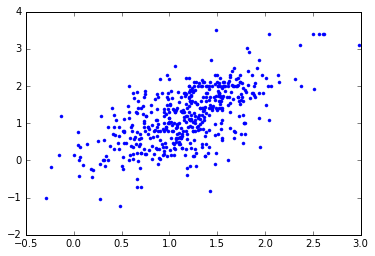

0.6294660347356246
0.43212294643519295
MSE: 0.3618631143319073


In [308]:
plt.plot(ridge_predicted,test_y,'.')
plt.show()
print np.corrcoef(ridge_predicted,test_y)[0,1]
tau,pval = kendalltau(ridge_predicted,test_y)
print tau
print 'MSE: '+repr(float(np.average([(ridge_predicted[i]-test_y[i])**2 for i in range(len(test_y))])))

## Ridge regression using just the amino acid counts

In [309]:
def sequence_to_aa_counts(sequence,cterm_amidation):
    to_return = []
    for char in CHARACTER_LIST:
        to_return.append(sequence.count(char))
    if cterm_amidation>0.5:
        to_return.append(1)
    else:
        to_return.append(0)
    return to_return

In [310]:
alphas_to_test = [0.0001,0.001,0.01,0.1,1,10,100,1000]
ridge_train_counts = RidgeCV(alphas=alphas_to_test)
ridge_train_counts.fit(test_x_aa_counts,test_y)
print ridge_train_counts.alpha_

100.0


In [311]:
alphas_to_test = [0.0001,20,40,60,70,75,78,80,81,82,83,85,90,100,120,140,160,320,640]
ridge_train_counts = RidgeCV(alphas=alphas_to_test)
ridge_train_counts.fit(test_x_aa_counts,test_y)
print ridge_train_counts.alpha_

81.0


In [312]:
ridge_predicted_counts = ridge_train_counts.predict(test_x_aa_counts)

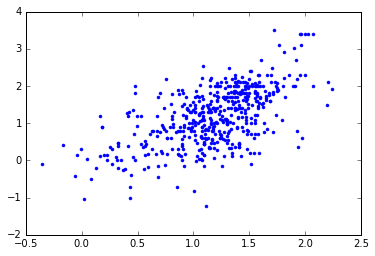

In [313]:
plt.plot(ridge_predicted_counts,test_y,'.')
plt.show()

In [314]:
print np.corrcoef(ridge_predicted_counts,test_y)[0,1]
tau,pval = kendalltau(ridge_predicted_counts,test_y)
print tau
print 'MSE: '+repr(float(np.average([(ridge_predicted_counts[i]-test_y[i])**2 for i in range(len(test_y))])))

0.595300022943397
0.40678085628613286
MSE: 0.3884282175075926


## Neural network analysis and comparisons

In [292]:
# conv_model_normal = conv_model()
# conv_model_normal.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_one_layer = one_layer_conv_model()
# conv_model_one_layer.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_moved_dropout = conv_model_move_dropout()
# conv_model_moved_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_p9_dropout = conv_model_set_dropout(dropout_level=0.9)
# conv_model_p9_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_p7_dropout = conv_model_set_dropout(dropout_level=0.7)
# conv_model_p7_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_p3_dropout = conv_model_set_dropout(dropout_level=0.3)
# conv_model_p3_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# rnn_one_layer = one_layer_recurrent_model()
# rnn_one_layer.fit(train_x,train_y,batch_size=40,epochs=100)

# rnn_two_layers = two_layer_recurrent_model()
# rnn_two_layers.fit(train_x,train_y,batch_size=40,epochs=100)

# rnn_three_layers = three_layer_recurrent_model()
# rnn_three_layers.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_mod = lstm_model()
# lstm_mod.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_rnn = birecurrent_model()
# bi_rnn.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_lstm = bilstm_model()
# bi_lstm.fit(train_x,train_y,batch_size=40,epochs=100)

bi_lstm_300 = bilstm_model()
bi_lstm_300.fit(train_x,train_y,batch_size=40,epochs=300)

Epoch 1/300
2840/2840 [==============================] - 10s 4ms/step - loss: 0.8779
Epoch 2/300
2840/2840 [==============================] - 7s 3ms/step - loss: 0.4895
Epoch 3/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4331
Epoch 4/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4329
Epoch 5/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4306
Epoch 6/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4195
Epoch 7/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4192
Epoch 8/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4109
Epoch 9/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.4032
Epoch 10/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.3985
Epoch 11/300
2840/2840 [==============================] - 8s 3ms/step - loss: 0.3919
Epoch 12/300
2840/2840 [==============================] - 8s 3ms/step - l

In [301]:
def evaluate_model(model):
    predicted = model.predict(test_x)
    predicted = [pred[0] for pred in predicted]
#     plt.plot(predicted,test_y,'.')
#     plt.show()
    print 'MSE: '+repr(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))])))
    print 'Pearson Correlation: '+repr(float(np.corrcoef(predicted,test_y)[1,0]))
    tau,pval = kendalltau(predicted,test_y)
    print 'Kendall tau Correlation: '+repr(tau)

In [302]:
evaluate_model(conv_model_normal)
evaluate_model(conv_model_one_layer)
evaluate_model(conv_model_moved_dropout)
evaluate_model(conv_model_p9_dropout)
evaluate_model(conv_model_p7_dropout)
evaluate_model(conv_model_p3_dropout)
evaluate_model(rnn_one_layer)
evaluate_model(rnn_two_layers)
evaluate_model(rnn_three_layers)
evaluate_model(lstm_mod)
evaluate_model(bi_rnn)
evaluate_model(bi_lstm)
evaluate_model(bi_lstm_300)

MSE: 0.2630187586654806
Pearson Correlation: 0.7627362163345807
Kendall tau Correlation: 0.5612715504824447
MSE: 0.2584475916238433
Pearson Correlation: 0.7576183875498322
Kendall tau Correlation: 0.5621919192451926
MSE: 0.291193032757182
Pearson Correlation: 0.7172390341786713
Kendall tau Correlation: 0.5130571447707726
MSE: 0.2917004792824526
Pearson Correlation: 0.724370655856039
Kendall tau Correlation: 0.5228744115734171
MSE: 0.26593463689024033
Pearson Correlation: 0.748867914454111
Kendall tau Correlation: 0.5449794086997665
MSE: 0.2623273522133445
Pearson Correlation: 0.7536921366086584
Kendall tau Correlation: 0.5539893344824567
MSE: 0.5466149751475964
Pearson Correlation: 0.32500182724698656
Kendall tau Correlation: 0.2162947326559626
MSE: 0.5999652913986262
Pearson Correlation: 0.1057590638773826
Kendall tau Correlation: 0.10807681930124084
MSE: 0.5993964651540502
Pearson Correlation: 0.09598610295951966
Kendall tau Correlation: 0.02198220377758971
MSE: 0.3408747920881625
Pe

In [56]:
convmodel_embed = conv_model(embed_length = (len(b62_embedding['A'])+1))
convmodel_embed.fit(ecoli_train_input_embed[0],ecoli_train_input_embed[1],batch_size=40,epochs=100)
convmodel_one_hot = conv_model()
convmodel_one_hot.fit(ecoli_train_input_one_hot[0],ecoli_train_input_one_hot[1],batch_size=40,epochs=100)

Epoch 1/100
2895/2895 [==============================] - 1s 418us/step - loss: 0.6799
Epoch 2/100
2895/2895 [==============================] - 1s 312us/step - loss: 0.4690
Epoch 3/100
2895/2895 [==============================] - 1s 306us/step - loss: 0.3912
Epoch 4/100
2895/2895 [==============================] - 1s 305us/step - loss: 0.3743
Epoch 5/100
2895/2895 [==============================] - 1s 307us/step - loss: 0.3451
Epoch 6/100
2895/2895 [==============================] - 1s 302us/step - loss: 0.3310
Epoch 7/100
2895/2895 [==============================] - 1s 308us/step - loss: 0.3065
Epoch 8/100
2895/2895 [==============================] - 1s 322us/step - loss: 0.2910
Epoch 9/100
2895/2895 [==============================] - 1s 316us/step - loss: 0.2822
Epoch 10/100
2895/2895 [==============================] - 1s 424us/step - loss: 0.2745
Epoch 11/100
2895/2895 [==============================] - 1s 329us/step - loss: 0.2470
Epoch 12/100
2895/2895 [============================

In [88]:
rnnmodel_one_hot = recurrent_model()
rnnmodel_one_hot.fit(ecoli_train_input_one_hot[0],ecoli_train_input_one_hot[1],batch_size=40,epochs=100)
# convmodel_one_hot = conv_model()
# convmodel_one_hot.fit(ecoli_train_input_one_hot[0],ecoli_train_input_one_hot[1],batch_size=40,epochs=100)

Epoch 1/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.7644
Epoch 2/100
2895/2895 [==============================] - 4s 2ms/step - loss: 0.6333
Epoch 3/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6238
Epoch 4/100
2895/2895 [==============================] - 4s 2ms/step - loss: 0.6278
Epoch 5/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6215
Epoch 6/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6221
Epoch 7/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6224
Epoch 8/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6169
Epoch 9/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6325
Epoch 10/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6218
Epoch 11/100
2895/2895 [==============================] - 5s 2ms/step - loss: 0.6216
Epoch 12/100
2895/2895 [==============================] - 5s 2ms/step - lo

In [90]:
print rnnmodel_one_hot.evaluate(test_x_one_hot,test_y)

509/509 [==============================] - 1s 1ms/step
0.4065361327413023


In [58]:
ecoli_test_input_embed = df_to_input_vec(ecoli_test,embed_dict=b62_embedding)
ecoli_test_input_one_hot = df_to_input_vec(ecoli_test)

In [60]:
test_x_embed = ecoli_test_input_embed[0]
test_x_one_hot = ecoli_test_input_one_hot[0]
test_y = ecoli_test_input_embed[1]

509/509 [==============================] - 0s 369us/step


0.2674829605637459

In [81]:
print convmodel_embed_one_hot.evaluate(test_x_one_hot,test_y)
print convmodel_embed.evaluate(test_x_embed,test_y)
print rnnmodel_embed.evaluate(test_x_embed,test_y)

509/509 [==============================] - 0s 152us/step
0.2674829605637459
509/509 [==============================] - 0s 150us/step
0.27840658735432655
509/509 [==============================] - 1s 1ms/step
0.32876440074682706


In [151]:
print convmodel_embed_one_hot.evaluate(test_x_one_hot,test_y)
print convmodel_embed.evaluate(test_x_embed,test_y)
print rnnmodel_embed.evaluate(test_x_embed,test_y)

509/509 [==============================] - 0s 327us/step
0.2674829605637459
509/509 [==============================] - 0s 240us/step
0.27840658735432655
509/509 [==============================] - 0s 756us/step
0.357846174938037


In [153]:
convmodel_embed_one_hot.predict(test_x_one_hot).shape

(509, 1)

In [154]:
len(test_y)

509

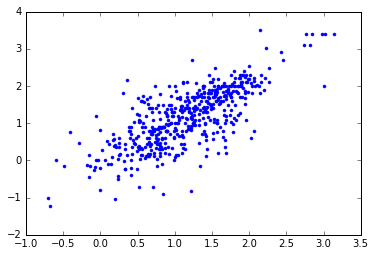

In [155]:
plt.plot(convmodel_embed_one_hot.predict(test_x_one_hot),test_y,'.')
plt.show()

In [161]:
np.corrcoef(test_y,convmodel_embed_one_hot.predict(test_x_one_hot).tolist())

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [183]:
thing=convmodel_embed_one_hot.predict(test_x_one_hot).tolist()
pred_y = [thing[i][0] for i in range(len(thing))]
testy = [test_y[i] for i in range(len(test_y))]

In [184]:
print len(pred_y)
print len(testy)
print np.corrcoef(np.array([pred_y,test_y]))

509
509
[[1.         0.75093691]
 [0.75093691 1.        ]]


In [182]:
print pred_y

[[0.00018078088760375977], [0.804699718952179], [0.41527310013771057], [0.65059494972229], [0.2572363615036011], [0.6929062008857727], [0.6024726629257202], [1.3883743286132812], [0.4464077651500702], [2.974808931350708], [0.24348585307598114], [0.8983182311058044], [0.5257531404495239], [0.6965836882591248], [1.5194125175476074], [0.7731612920761108], [1.1550123691558838], [0.9067221283912659], [1.3859975337982178], [1.0199246406555176], [1.1168525218963623], [1.0979042053222656], [1.7597465515136719], [0.26230213046073914], [1.6937675476074219], [0.4183138906955719], [0.38670843839645386], [1.4011256694793701], [0.42569535970687866], [-0.4939499497413635], [0.8234257102012634], [1.7153122425079346], [1.5677518844604492], [2.03965163230896], [0.29985901713371277], [1.457822322845459], [1.2377314567565918], [2.1349802017211914], [0.8958069086074829], [1.537076473236084], [0.6268340945243835], [2.0093462467193604], [1.1671497821807861], [1.6529231071472168], [1.3630664348602295], [1.101

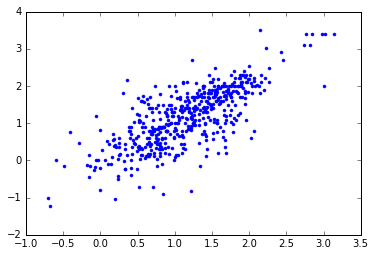

In [168]:
plt.plot(thing,test_y,'.')
plt.show()

In [170]:
np.average([(thing[i]-test_y[i])**2 for i in range(len(thing))])

0.2674829647269796

In [171]:
np.average([(ridge_predicted[i]-test_y[i])**2 for i in range(len(thing))])

0.37463669061385213